## Makemore Part 4: becoming a backprop ninja
Manually coding our backpropagation 
https://www.youtube.com/watch?v=q8SA3rM6ckI&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=5&pp=iAQB

In [143]:
# Run using python 3.8.5 kernel 
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline

In [144]:
words = open('names.txt', 'r').read().splitlines() 
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [145]:
# build vocab of chars and mapping to / from integers
chars = sorted(list(set(''.join(words)))) # get all distinct chars, sorted
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [146]:
# build dataset
block_size = 3 

def build_dataset(words): 

    X, Y = [], [] 

    for w in words: 
        context = [0] * block_size 
        for ch in w + '.': 
            ix = stoi[ch]  
            X.append(context) 
            Y.append(ix) 
            context = context[1:] + [ix] 

    X = torch.tensor(X) 
    Y = torch.tensor(Y) 
    print(X.shape, Y.shape)
    return X, Y 

import random 
random.seed(42) 
random.shuffle(words) # mix up the words 
n1 = int(0.8*len(words)) # 80% of words 
n2 = int(0.9*len(words)) # 90% of words 

Xtr, Ytr = build_dataset(words[:n1]) 
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [147]:
# utility function he created 
# checking our gradients vs. pytorch's gradients: are we correct? 
def cmp(s, dt, t): 
    ex = torch.all(dt == t.grad).item() # are they exactly equal? 
    app = torch.allclose(dt, t.grad) # are they approximately equal according to allclose? 
    maxdiff = (dt - t.grad).abs().max().item() # biggest diff between our grads and pytorch's
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [148]:
n_embd = 10 
n_hidden = 64 

## Note that these are initialized in non-standard ways bc otherwise our 
# backprop could be too easy
# He also notes b1 is spurious here, but I would've thought both b2?  

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
# Layer 1 
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden,                          generator=g) * 0.1
# Layer 2 
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.1 
b2 = torch.randn(vocab_size,                        generator=g) * 0.1 
# Batchnorm parameters 
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0 
bnbias = torch.randn((1, n_hidden)) * 0.1 

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters: 
    p.requires_grad = True

4137


In [149]:
batch_size = 32 
n = batch_size # shorter variable also for convenience 

# constructing one minibatch 
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [150]:
# forward pass, but chunked into smaller steps that we can backward one at a time 

emb = C[Xb] # embed chars into vectors 
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors 

# Linear layer 1 
hprebn = embcat @ W1 + b1 # hidden layer pre-activation (i.e. pre tanh etc.)
# Batchnorm layer 
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani 
bndiff2 = bndiff**2 
bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv 
hpreact = bngain * bnraw + bnbias 
# Non-linearity (activation) 
h = torch.tanh(hpreact) # hidden layer 

# Linear layer 2 
logits = h @ W2 + b2 
# cross entropy loss 
logit_maxes = logits.max(1, keepdim=True).values 
# subtract max for numerical stability -- don't want exp to overflow
# this won't affect the logprobs down the line bc we subtract the same amt from everything
norm_logits = logits - logit_maxes 
counts = norm_logits.exp() 
counts_sum = counts.sum(1, keepdims=True) 
counts_sum_inv = counts_sum**-1 
probs = counts * counts_sum_inv 
logprobs = probs.log() 
loss = -logprobs[range(n), Yb].mean() 

# Pytorch backward pass 
for p in parameters: 
    p.grad = None 
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, 
          norm_logits, logit_maxes, logits, h, hpreact, bnraw, 
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, 
          embcat, emb]: 
    t.retain_grad() 
loss.backward() 
loss 


tensor(3.3126, grad_fn=<NegBackward0>)

## Exercise 1: backprop thru the whole thing manually 
## backpropagating as defined above, one by one
Example: 
dloss / da is -1/n for all the correct element indexes (e.g. if for example 1 
char 5 is correct, gradient for that element is -1/n bc loss is negative mean 
of logprobs)
the other logprob values don't participate / affect the loss  

Example 2: 
dprobs is the local derivative of logprobs w/ respect to probs, multiplied by 
derivative of loss w respect to logprobs 

In [99]:
dlogprobs = torch.zeros_like(logprobs) 
dlogprobs[range(n), Yb] = -1.0 / n 

# Note this one super logical bc if prob is very high like 1, dlogprobs just 
# gets passed through. If prob (of correct value) is low that's bad, so 
# gradient gets boosted (we need more change) 
dprobs = (1.0/probs) * dlogprobs 

# We have to sum here bc counts_sum_inv is actually not the same dimension 
# as counts -- it's a column that gets replicated 27 times. And the node 
# accumulates all those gradients (or can think of it as all that power over L) -- 
# we need to sum that up 
dcounts_sum_inv = (counts * dprobs).sum(1, keepdims=True) 
# this one 32x1 and 32x27, counts_sum_inv will broadcast to get correct result 
dcounts = counts_sum_inv * dprobs 
dcounts_sum = -counts_sum**-2 * dcounts_sum_inv 

# note here that dcounts_sum is one column; dcounts is 32x27 
# we want to take a 1-column derivative and transform it into a 32x27 derivative 
# and sum means that each element has local derivative 1 
# **Note also this is a second branch of dcounts gradient! Need to add it to the above one! 
dcounts += torch.ones_like(counts) * dcounts_sum

# nice and simple bc it's element-wise
# (counts here is norm_logits.exp(), we're just reusing the calculation)
dnorm_logits = counts * dcounts  

# logit_maxes also getting broadcast here 
# basically can remember: if a vector is getting broadcast, you've gotta sum the gradients 
# I think of this as creating a 32x27 of -1s, then multiplying that by dnorm_logits, 
# and THEN adding those elements together 
dlogits = dnorm_logits.clone() # think of it as 1s * dnorm_logits
dlogit_maxes = -dnorm_logits.sum(1, keepdim=True)

# for the line logit_maxes = logit.max(1, keepdim=True).values 
# the gradient should be 1 for the entries that were 'plucked out' as the max in each row 
# for the rest, it should be 0 
# and dlogit_maxes is broadcasting here 
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

# time to get into some matrices 
# basically, the derivative for c = a @ b is going to be b.T or a.T, 
# for a and b respectively. And if you look at the dims of the matrices, there's 
# only one way for it to work out with dc (a.T @ dc for example)
# and the bias makes sense bc one row becomes many; you sum to eliminate the column dimension
dh = dlogits @ W2.T
dW2 = h.T @ dlogits 
db2 = dlogits.sum(0, keepdims=True)

# backpropagating thru a tanh 
dhpreact = (1.0 - h**2) * dh 
dbngain = (bnraw * dhpreact).sum(0, keepdim=True) 
dbnraw = bngain * dhpreact 
dbnbias = dhpreact.sum(0, keepdim=True)

dbndiff = bnvar_inv * dbnraw 
# nice to think of this sum also as a sum across examples 
# bc bias-type vars apply the same way to every example 
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = -0.5 * ((bnvar + 1e-5)**-1.5) * dbnvar_inv

# anytime there's a sum in the forwar pass, something will have to broadcast
# in the backward pass. Here dbnvar is broadcasting 
# And vice versa! 
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar 
dbndiff += 2*bndiff * dbndiff2 # another branch of one we drafted -- thus += 

# broadcasting in forward pass = variable reuse = sum in backward pass 
dhprebn = dbndiff.clone() # he uses clones (exact copy) for "safety" 
dbnmeani = -dbndiff.sum(0, keepdim=True) 
dhprebn += (1.0/n) * torch.ones_like(hprebn) * dbnmeani 

# first layer 
dembcat = dhprebn @ W1.T 
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

demb = dembcat.view(emb.shape) # just reimagine embcat in the original shape of emb

dC = torch.zeros_like(C) 
for k in range(Xb.shape[0]): 
    for j in range(Xb.shape[1]): 
        ix = Xb[k,j] # e.g., 3 for letter d 
        dC[ix] += demb[k,j] # deposit emb's gradient for the corresponding vector 

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [100]:
hprebn.shape, embcat.shape, W1.shape, b1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

### Exercise 2: backprop thru cross entropy but all in one go 

In [101]:
loss_fast = F.cross_entropy(logits, Yb) 
print(loss_fast.item(), 'diff:', (loss_fast-loss).item())

3.364447593688965 diff: -2.384185791015625e-07


In [102]:
# he showed some calculus. bit complex but simplifies down a lot 
dlogits = F.softmax(logits, 1) 
dlogits[range(n), Yb] -= 1 # gradient depends on whether element is the correct one or not 
dlogits /= n # loss is average of losses, gradient needs to be scaled down too 

cmp('logits', dlogits, logits) # tiny tiny off 

logits          | exact: False | approximate: True  | maxdiff: 7.2177499532699585e-09


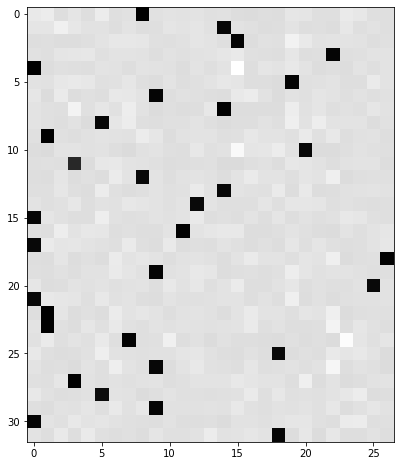

In [103]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [104]:
F.softmax(logits, 1)[0] # looking at first example 

tensor([0.0690, 0.0838, 0.0197, 0.0501, 0.0206, 0.0841, 0.0242, 0.0348, 0.0163,
        0.0308, 0.0410, 0.0367, 0.0403, 0.0277, 0.0348, 0.0144, 0.0093, 0.0190,
        0.0159, 0.0538, 0.0486, 0.0220, 0.0235, 0.0736, 0.0599, 0.0244, 0.0219],
       grad_fn=<SelectBackward0>)

In [105]:
# think of this as force
# we're gonna pull down on the probability of the wrong chars
# and we're gonna pull up on the probability of the correct one 
# (correct one is the only negative one here, I think meaning loss decreases if we boost it)
# our application of force depends on how incorrect our predictions were 
dlogits[0] * n 

tensor([ 0.0690,  0.0838,  0.0197,  0.0501,  0.0206,  0.0841,  0.0242,  0.0348,
        -0.9837,  0.0308,  0.0410,  0.0367,  0.0403,  0.0277,  0.0348,  0.0144,
         0.0093,  0.0190,  0.0159,  0.0538,  0.0486,  0.0220,  0.0235,  0.0736,
         0.0599,  0.0244,  0.0219], grad_fn=<MulBackward0>)

In [106]:
# overall repulsion/attraction is equal 
dlogits[0].sum()

tensor(9.3132e-10, grad_fn=<SumBackward0>)

### Exercise 3: backprop through batchnorm, all in one go 

In [107]:
# Need to debug this -- why getting such a big diff? 
# fixed now, had redefined bnbias above instead of dbnbias 
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [108]:
hpreact_fast, hpreact

(tensor([[-0.6665, -1.5681,  0.8980,  ...,  2.0226, -0.5969,  0.3400],
         [-1.4487,  0.0939, -1.0534,  ..., -0.5668,  0.1939, -0.7310],
         [-0.7711,  1.1059,  1.4311,  ...,  0.4884, -1.0139,  0.3550],
         ...,
         [ 0.0949, -0.1989,  0.2809,  ..., -0.3989,  0.0875,  0.4894],
         [-1.1292, -2.0728,  1.0126,  ...,  0.5216,  1.5801, -1.6328],
         [ 1.9189, -0.2238, -0.0079,  ..., -0.7749, -1.9075, -0.6047]],
        grad_fn=<AddBackward0>),
 tensor([[-0.6665, -1.5681,  0.8980,  ...,  2.0226, -0.5969,  0.3400],
         [-1.4487,  0.0939, -1.0534,  ..., -0.5668,  0.1939, -0.7310],
         [-0.7711,  1.1059,  1.4311,  ...,  0.4884, -1.0139,  0.3550],
         ...,
         [ 0.0949, -0.1989,  0.2809,  ..., -0.3989,  0.0875,  0.4894],
         [-1.1292, -2.0728,  1.0126,  ...,  0.5216,  1.5801, -1.6328],
         [ 1.9189, -0.2238, -0.0079,  ..., -0.7749, -1.9075, -0.6047]],
        grad_fn=<AddBackward0>))

In [109]:
# our derivatives are exactly the same... then why our values so different? 
# pretty complicated to get here -- in parallel, applying a complex derivative formula 
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


## Exercise 4: putting it all together
redefining functions with manual backprop 

In [135]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience

12297


In [136]:
max_steps = 200000 
lossi = []

with torch.no_grad(): 
    for i in range(max_steps): 
        # minibatch 
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]

        # forward pass 
        emb = C[Xb] # embed chars into vectors 
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors 

        # Linear layer 1 
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation (i.e. pre tanh etc.)
        # Batchnorm layer 
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv 
        hpreact = bngain * bnraw + bnbias 
        # Non-linearity (activation) 
        h = torch.tanh(hpreact) # hidden layer 
        # Linear layer 2 
        logits = h @ W2 + b2 
        loss = F.cross_entropy(logits, Yb) 

        for p in parameters: 
            p.grad = None 
        # loss.backward()

        # manual backprop 
        # first, logits
        dlogits = F.softmax(logits, 1) 
        dlogits[range(n), Yb] -= 1 
        dlogits /= n 
        # 2nd layer 
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits 
        db2 = dlogits.sum(0)
        # tanh 
        dhpreact = (1.0 - h**2) * dh 
        # batchnorm 
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True) 
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
        # 1st layer 
        dembcat = dhprebn @ W1.T 
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding 
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C) 
        for k in range(Xb.shape[0]): 
            for j in range(Xb.shape[1]): 
                ix = Xb[k,j] # e.g., 3 for letter d 
                dC[ix] += demb[k,j] # deposit emb's gradient for the corresponding vector 

        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

        # update 
        lr = 0.1 if i < 100000 else 0.01 
        for p, grad in zip(parameters, grads): 
            # p.data += -lr * p.grad # need to update
            p.data += -lr * grad 

        if i % 10000 == 0: 
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
            lossi.append(loss.log10().item())

        # if i >= 100: 
        #     break 


      0/ 200000: 3.7733
  10000/ 200000: 2.1969
  20000/ 200000: 2.3853
  30000/ 200000: 2.4146
  40000/ 200000: 2.0234
  50000/ 200000: 2.4041
  60000/ 200000: 2.3364
  70000/ 200000: 2.0575
  80000/ 200000: 2.3676
  90000/ 200000: 2.1796
 100000/ 200000: 1.9514
 110000/ 200000: 2.3410
 120000/ 200000: 2.0097
 130000/ 200000: 2.4040
 140000/ 200000: 2.3332
 150000/ 200000: 2.1821
 160000/ 200000: 2.0361
 170000/ 200000: 1.8173
 180000/ 200000: 2.0636
 190000/ 200000: 1.9300


In [137]:
# # checking our grads against pytorch 
# for p, g in zip(parameters, grads): 
#     cmp(str(tuple(p.shape)), g, p)

In [139]:
# calibrate the batch norm at the end 
with torch.no_grad(): 
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 
    bnmean = hpreact.mean(0, keepdim=True) 
    bnvar = hpreact.var(0, keepdim=True,  unbiased=True) 

In [ ]:
# evaluate train and val loss 
# looks good! similar to before 
@torch.no_grad() # this decorator disables gradient tracking 
def split_loss(split): 
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1
    # these are adjusted to use our calibrated batch norm
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0710809230804443
val 2.1087210178375244


In [ ]:
# lookin decent 
g = torch.Generator().manual_seed(12345)  

for _ in range(20): 
    out = []
    context = [0] * block_size 
    while True: 
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1 
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias 
        h = torch.tanh(hpreact) 
        logits = h @ W2 + b2 

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() 
        context = context[1:] + [ix]
        out.append(ix) 
        if ix == 0: 
            break 

    print(''.join(itos[i] for i in out))

junee.
noworu.
chel.
maevaya.
zanni.
talitzelyana.
alie.
lob.
haybetse.
bran.
henon.
thellee.
tavir.
anne.
elliet.
keyden.
jecir.
klor.
malyine.
abelle.
